In [1]:
%matplotlib inline
from options.base_options import BaseOptions
from utils.upscale import Upscale
from datasets.climate_dataset import ClimateDataset
from models.gamma_vae import GammaVae

import scipy.stats
import numpy as np

import torch
import os
from netCDF4 import Dataset

import matplotlib.pyplot as plt


In [2]:
def normalized_flux_to_mm_per_d(pr_norm_flux, std):
    return pr_norm_flux * std * 60 * 60 * 24

In [96]:
with Dataset(os.path.join('data', 'wind_psl', 'pr.std.nc4'), "r", format="NETCDF4") as file:
    std = file['pr'][0].item()
with Dataset(os.path.join('data', 'wind_psl', 'orog.std.nc4'), "r", format="NETCDF4") as file:
    std_orog = file['orog'][0].item()

## Load different models

In [7]:
def load_model(opt):
    # Directory of the saved model
    load_root = os.path.join('checkpoints', opt.name)
    load_epoch = opt.load_epoch if opt.load_epoch >= 0 else 'latest'
    load_name = "epoch_{}.pth".format(load_epoch)
    load_dir = os.path.join(load_root, load_name)
    device = torch.device("cuda" if len(opt.gpu_ids) > 0 else "cpu")

    model = GammaVae(opt=opt, device=device).to(device)
    model.load_state_dict(torch.load(load_dir, map_location='cpu'))
    model.eval()
    return model


In [8]:
models = {}

### 1. load standard model

In [9]:
base_opt = BaseOptions()
opt = base_opt.parse(args=['--batch_size', '128',

                           '--gpu_ids', '-1',
                           '--load_epoch', '14',
                           '--log_interval', '1000',
                           '--model', 'mse_vae',
                           '--n_epochs', '15',
                           '--n_test', '2',
                           '--n_threads', '4',
                           '--n_val', '2',
                           '--name', '02_13_mse',
                           '--nf_decoder', '32',
                           '--nf_encoder', '32',
                           '--no_dropout',
                           '--nz', '40',
                           '--phase', 'test',
                           '--plot_interval', '1000',
                           '--save_interval', '1', 
                           '--save_latest_interval', '5000',
                           '--seed', '1'])
models['standardSDVAE'] = load_model(opt)

------------ Options -------------
batch_size: 128
eval_val_loss: 100
gpu_ids: -1
load_epoch: 14
log_interval: 1000
model: mse_vae
n_epochs: 15
n_test: 2
n_threads: 4
n_val: 2
name: 02_13_mse
nf_decoder: 32
nf_encoder: 32
no_dropout
no_orog: False
nz: 40
phase: test
plot_interval: 1000
regression: False
save_interval: 1
save_latest_interval: 5000
seed: 1
-------------- End ----------------


### 2. Load gamma model

In [10]:
base_opt = BaseOptions()
opt = base_opt.parse(args=['--batch_size', '128',

                           '--gpu_ids', '-1',
                           '--load_epoch', '14',
                           '--log_interval', '1000',
                           '--model', 'gamma_vae',
                           '--n_epochs', '15',
                           '--n_test', '2',
                           '--n_threads', '4',
                           '--n_val', '2',
                           '--name', '02_13_gamma',
                           '--nf_decoder', '32',
                           '--nf_encoder', '32',
                           '--no_dropout',
                           '--nz', '40',
                           '--phase', 'test',
                           '--plot_interval', '1000',
                           '--save_interval', '1', 
                           '--save_latest_interval', '5000',
                           '--seed', '1'])
models['gammaSDVAE'] = load_model(opt)

------------ Options -------------
batch_size: 128
eval_val_loss: 100
gpu_ids: -1
load_epoch: 14
log_interval: 1000
model: gamma_vae
n_epochs: 15
n_test: 2
n_threads: 4
n_val: 2
name: 02_13_gamma
nf_decoder: 32
nf_encoder: 32
no_dropout
no_orog: False
nz: 40
phase: test
plot_interval: 1000
regression: False
save_interval: 1
save_latest_interval: 5000
seed: 1
-------------- End ----------------


### 3. load regression_model

## Load data (similar for all models)

In [11]:
base_opt = BaseOptions()
opt = base_opt.parse(args=['--batch_size', '128',

                           '--gpu_ids', '-1',
                           '--load_epoch', '14',
                           '--log_interval', '1000',
                           '--model', 'mse_vae',
                           '--n_epochs', '15',
                           '--n_test', '2',
                           '--n_threads', '4',
                           '--n_val', '2',
                           '--name', '02_13_deterministic',
                           '--nf_decoder', '32',
                           '--nf_encoder', '32',
                           '--no_dropout',
                           '--nz', '40',
                           '--phase', 'test',
                           '--plot_interval', '1000',
                           '--save_interval', '1', 
                           '--save_latest_interval', '5000',
                           '--seed', '1',
                           '--regression'])
models['regressionSDVAE'] = load_model(opt)

------------ Options -------------
batch_size: 128
eval_val_loss: 100
gpu_ids: -1
load_epoch: 14
log_interval: 1000
model: mse_vae
n_epochs: 15
n_test: 2
n_threads: 4
n_val: 2
name: 02_13_deterministic
nf_decoder: 32
nf_encoder: 32
no_dropout
no_orog: False
nz: 40
phase: test
plot_interval: 1000
regression
save_interval: 1
save_latest_interval: 5000
seed: 1
-------------- End ----------------


## Load data (similar for all models)

In [12]:
climate_data = ClimateDataset(opt=opt, phase=opt.phase)
input_dataset = Dataset(os.path.join(opt.dataroot, 'dataset.nc4'), "r", format="NETCDF4")
# large_cell = 48x48, cell = 40x40, small_cell = 32x32
large_cell = opt.fine_size + 2*opt.scale_factor
device = torch.device("cuda" if len(opt.gpu_ids) > 0 else "cpu")
upscaler = Upscale(size=opt.fine_size+2*opt.scale_factor, scale_factor=opt.scale_factor, device=device)

In [13]:
idx_lat = 2
idx_lon = climate_data.lat_lon_list[idx_lat][0]

# calculate upper left index for cell with boundary values to downscale #todo better formulation
anchor_lat = idx_lat * climate_data.cell_size  + climate_data.scale_factor
anchor_lon = idx_lon * climate_data.cell_size
# select indices for a 48 x 48 box around the 32 x 32 box to be downscaled (with boundary values)
large_cell_lats = [i for i in
                   range(anchor_lat - climate_data.scale_factor,
                         anchor_lat + climate_data.fine_size + climate_data.scale_factor)]
# longitudes might cross the prime meridian
large_cell_lons = [i % 720
                   for i in
                   range(anchor_lon - climate_data.scale_factor,
                         anchor_lon + climate_data.fine_size + climate_data.scale_factor)]
# create output path
print("lat: {}\t lon: {}".format(anchor_lat, anchor_lon))

orog = input_dataset['orog'][large_cell_lats, large_cell_lons]
pr = input_dataset['pr'][:, large_cell_lats, large_cell_lons]
uas = input_dataset['uas'][:, large_cell_lats, large_cell_lons]
vas = input_dataset['vas'][:, large_cell_lats, large_cell_lons]
psl = input_dataset['psl'][:, large_cell_lats, large_cell_lons]

lat: 88	 lon: 240


In [111]:
t = 2
# create reconstructed image
pr_tensor = torch.tensor(pr[t, :, :], dtype=torch.float32, device=device)
orog_tensor = torch.tensor(orog[:], 
                           dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
uas_tensor = torch.tensor(uas[t, :, :], dtype=torch.float32, device=device)
vas_tensor = torch.tensor(vas[t, :, :], dtype=torch.float32, device=device)
psl_tensor = torch.tensor(psl[t, :, :], dtype=torch.float32, device=device)


coarse_pr = upscaler.upscale(pr_tensor).unsqueeze(0).unsqueeze(0)
coarse_uas = upscaler.upscale(uas_tensor).unsqueeze(0).unsqueeze(0)
coarse_vas = upscaler.upscale(vas_tensor).unsqueeze(0).unsqueeze(0)
coarse_psl = upscaler.upscale(psl_tensor).unsqueeze(0).unsqueeze(0)

## Run Models

In [112]:
n_samples = 3

In [113]:
downscaled_samples = {}
z_list = [torch.randn(1, opt.nz, 1, 1, device=device) for i in range(n_samples)]
for model_name, model in models.items():
    recon_list = [] 
    for i in range(n_samples):
        with torch.no_grad():
            recon_pr=model.decode(z=z_list[i],
                                          coarse_pr=coarse_pr,coarse_uas=coarse_uas,
                                          coarse_vas=coarse_vas, orog=orog_tensor,
                                          coarse_psl=coarse_psl)
            if model_name != 'gammaSDVAE':
                recon_list.append(recon_pr)
            else:
                recon_list.append(torch.distributions.bernoulli.Bernoulli(recon_pr['p']).sample() *
                             torch.distributions.gamma.Gamma(recon_pr['alpha'],1/recon_pr['beta']).sample())
    downscaled_samples[model_name] = recon_list
    

In [114]:
models['gammaSDVAE'].decode(z=z_list[0],
                                          coarse_pr=coarse_pr,coarse_uas=coarse_uas,
                                          coarse_vas=coarse_vas, orog=orog_tensor,
                                          coarse_psl=coarse_psl)

{'p': tensor([[[[ 0.9987,  0.9998,  0.9999,  ...,  0.9999,  0.9998,  0.9990],
           [ 0.9992,  0.9998,  0.9999,  ...,  1.0000,  1.0000,  0.9998],
           [ 0.9993,  0.9998,  0.9998,  ...,  1.0000,  1.0000,  0.9999],
           ...,
           [ 0.0232,  0.0132,  0.0177,  ...,  0.1338,  0.1491,  0.2013],
           [ 0.0321,  0.0170,  0.0143,  ...,  0.0691,  0.1045,  0.2277],
           [ 0.0809,  0.0420,  0.0336,  ...,  0.0566,  0.0805,  0.1886]]]]),
 'alpha': tensor([[[[  3.0157,   5.1122,   7.0142,  ...,  10.3150,   7.9969,
              4.4172],
           [  4.5173,   8.1624,  11.6281,  ...,  23.3968,  19.2204,
              7.4195],
           [  4.3154,   7.0128,   8.5748,  ...,  31.7390,  24.9603,
             12.6789],
           ...,
           [  0.5992,   0.4766,   0.4770,  ...,   0.3534,   0.3550,
              0.3502],
           [  0.5620,   0.4845,   0.4104,  ...,   0.3191,   0.3790,
              0.3688],
           [  0.5980,   0.5553,   0.4568,  ...,   0.3315,

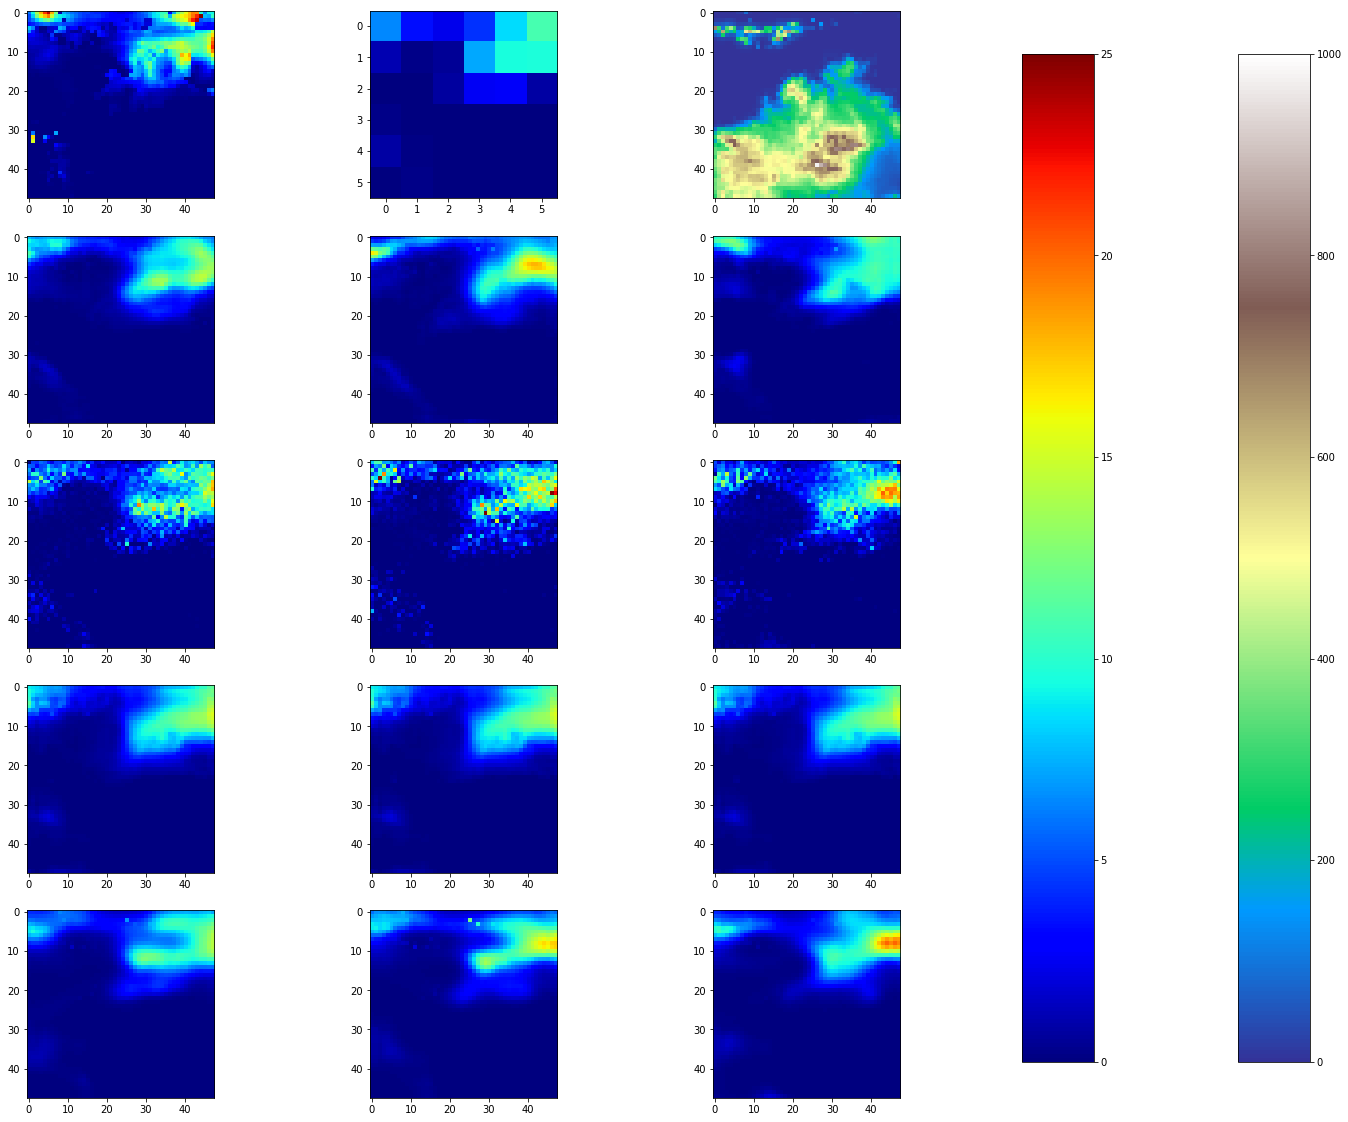

In [115]:
fig, axes = plt.subplots(len(models)+2, n_samples, figsize = (20, 20))
v_min = 0
v_max = 25
i = 0
im_pr = axes[0, 0].imshow(normalized_flux_to_mm_per_d(pr_tensor,std), cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)
axes[i, 1].imshow(normalized_flux_to_mm_per_d(coarse_pr[0,0,:,:],std),cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)
im_orog = axes[i, 2].imshow(orog_tensor[0,0,:,:]*std_orog,cmap=plt.get_cmap('terrain'),
                           vmin=0,vmax=1000)

for model_name, downscaled_sample in downscaled_samples.items():
    i += 1
    for j in range(n_samples):
        axes[i, j].imshow(
            normalized_flux_to_mm_per_d((downscaled_sample[j])[0,0,:,:],std),
            cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)
        

for j in range(n_samples):
        with torch.no_grad():
            recon_pr=models['gammaSDVAE'].decode(z=z_list[j],
                                          coarse_pr=coarse_pr,coarse_uas=coarse_uas,
                                          coarse_vas=coarse_vas, orog=orog_tensor,
                                          coarse_psl=coarse_psl)
        axes[i+1,j].imshow(normalized_flux_to_mm_per_d(
            (recon_pr['p'] * recon_pr['alpha'] * recon_pr['beta'])[0,0,:,:], std),
                           cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im_pr, cax=cbar_ax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(im_orog, cax=cbar_ax)


Text(0.5,1,'Orography South America')

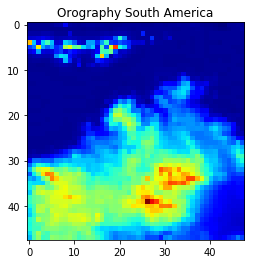

In [116]:
plt.imshow(orog_tensor[0,0,:,:], cmap=plt.get_cmap('jet'))
plt.title('Orography South America')


Text(0.5,1,'Example Daily Precipitation')

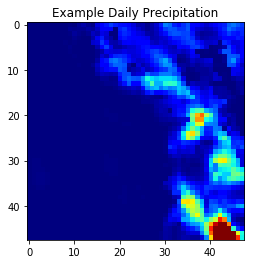

In [181]:
plt.imshow(pr_tensor,cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)
plt.title('Daily Precipitation')

In [31]:
n_interpolated = 4
z1=torch.randn(opt.nz)
z2=torch.randn(opt.nz)
s = torch.Tensor(np.linspace(start=0, stop=1, num=n_interpolated)).unsqueeze(0)

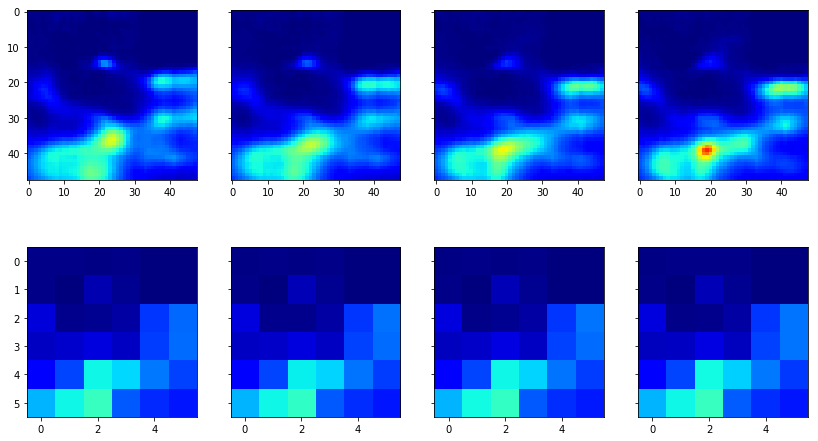

In [32]:
upscaler = Upscale(size=48, scale_factor=8, device=device)
interpolated = (z2 - z1).unsqueeze(1) * s
fig, axes = plt.subplots(2, n_interpolated, sharey='row', figsize = (14, 8))
for i in range(n_interpolated):
    z = (z1 + interpolated[:,i]).view(1,-1,1,1)
    with torch.no_grad():
        recon_pr = model.decode(z=z,coarse_pr=coarse_pr,coarse_uas=coarse_uas,
                            coarse_vas=coarse_vas, orog=orog_tensor, coarse_psl=coarse_psl)
    if opt.model=='gamma_vae':
        image = recon_pr['p']*recon_pr['alpha']*recon_pr['beta']
    elif opt.model=='mse_vae':
        image = recon_pr
    axes[0,i].imshow(image[0,0,:,:], cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)
    coarse_recon = upscaler.upscale(image)
    axes[1,i].imshow(coarse_recon[0,0,:,:], cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)

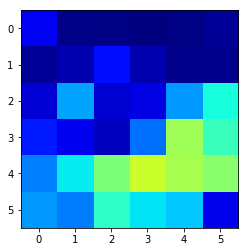

In [79]:
from utils.upscale import Upscale

upscaler = Upscale(size=48, scale_factor=8, device=device)
coarse_recon = upscaler.upscale(image)
plt.imshow(coarse_recon[0,0,:,:], cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)

NameError: name 'p_list' is not defined

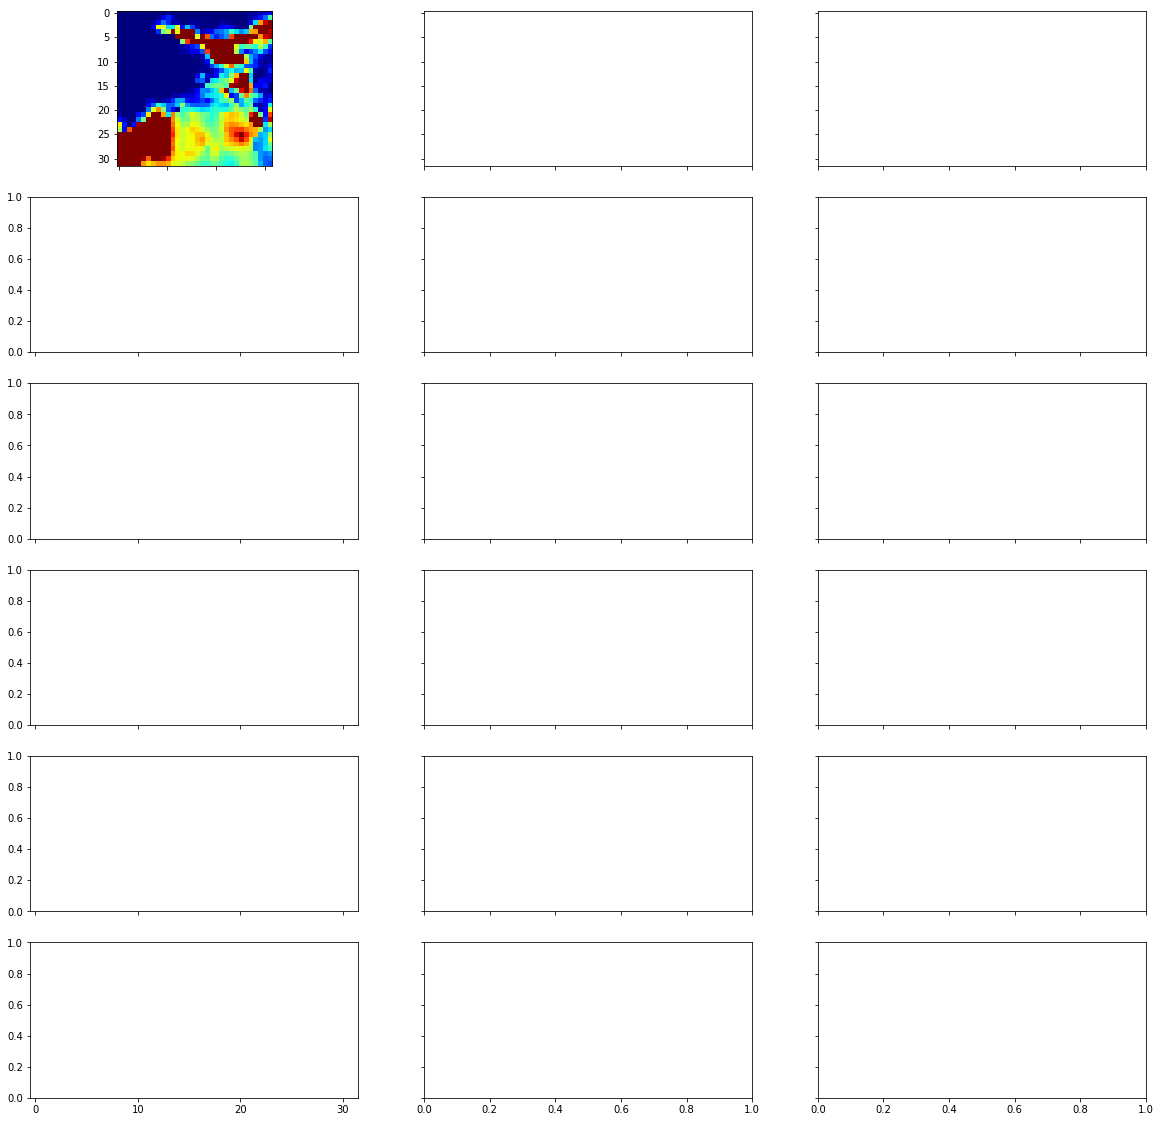

In [80]:
fig, axes = plt.subplots(6, opt.n_samples, sharex='col', sharey='row', figsize = (20, 20))
v_min = 0
v_max = 5
for i in range(opt.n_samples):
    axes[0, i].imshow(pr_tensor[opt.scale_factor:-opt.scale_factor, opt.scale_factor:-opt.scale_factor],
                              cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)
    axes[1, i].imshow(p_list[i][0,0,:,:], cmap=plt.get_cmap('Greys'), vmin=0, vmax=1)
    axes[2, i].imshow((p_list[i]*alpha_list[i]*beta_list[i])[0, 0, :, :], vmin=v_min, vmax=v_max, 
                      cmap=plt.get_cmap('jet'))
    axes[3, i].imshow(alpha_list[i][0,0,:,:], vmin=v_min, vmax=v_max,
                      cmap=plt.get_cmap('jet'))
    im = axes[4, i].imshow(beta_list[i][0,0,:,:], vmin=v_min, vmax=v_max,
                           cmap=plt.get_cmap('jet'))
    axes[5, i].imshow(orog_tensor[0,0,:,:],
                      cmap=plt.get_cmap('jet'))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

ValueError: not enough values to unpack (expected 3, got 1)

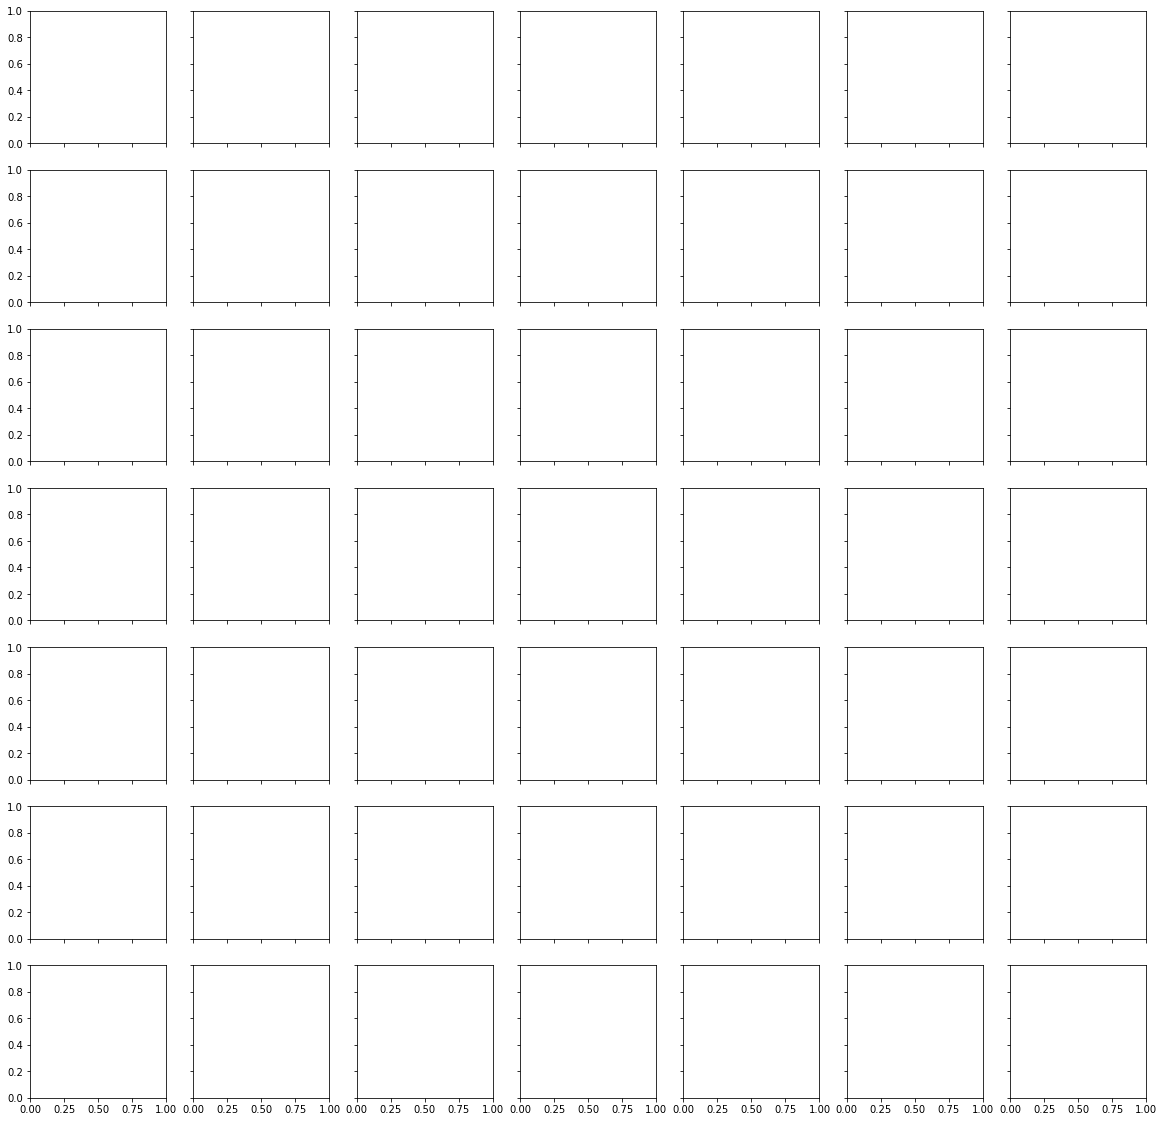

In [22]:
fig, axes = plt.subplots(7, 7, sharex='col', sharey='row', figsize = (20, 20))
z=torch.randn(1, opt.nz, 1, 1, device=device)
for i in range(7):
    for j in range(7):
        z[0,0,0,0] = scipy.stats.norm.ppf((i+1)/8)
        z[0,8,0,0] = scipy.stats.norm.ppf((j+1)/8)
        with torch.no_grad():
            p, alpha, beta = model.decode(z=z,
                                          coarse_pr=coarse_pr,coarse_uas=coarse_uas,
                                          coarse_vas=coarse_vas, orog=orog_tensor)
        axes[i, j].imshow((p 
                           * alpha * beta
                          )[0,0,:,:], vmin=v_min, vmax=v_max,cmap=plt.get_cmap('jet'))
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [13]:
recon_list[1]

tensor([[[[-1.0211, -1.0716, -1.0716,  ..., -1.0716, -1.0716, -0.6841],
          [-1.0716, -1.0716, -1.0716,  ..., -1.0716, -1.0716, -1.0716],
          [-1.0716, -1.0716, -1.0716,  ..., -1.0716, -1.0716, -1.0716],
          ...,
          [-0.9758, -1.0716, -1.0716,  ..., -1.0716, -1.0716, -1.0716],
          [-0.7685, -0.9764, -1.0422,  ..., -1.0716, -1.0716, -1.0716],
          [-0.5144, -0.7093, -0.7762,  ..., -1.0716, -1.0716, -0.8494]]]])